In [2]:
import os
import pandas as pd
import numpy as np
import re
os.chdir(r"C:\Users\vladick\Desktop\WBTECH")

In [98]:
text = pd.read_parquet('text_data.parquet')

In [99]:
text['colornames'] = text['colornames'].fillna(text['Цвет'])

text['Длина юбки/платья'] = text['Длина юбки/платья'].fillna(text['Длина юбки\платья'])

text.drop(columns=['Цвет', 'Длина юбки\платья', 'Длина упаковки', 'Высота упаковки', 'Ширина упаковки', 'ИКПУ',
                   'Рост модели на фото', 'Код упаковки','Номер сертификата соответствия',
                   'Дата регистрации сертификата/декларации'], inplace=True)

In [100]:
text.drop(columns=['Ставка НДС', 'Номер декларации соответствия', 'Дата окончания действия сертификата/декларации',
                  'Пол'], inplace=True)

In [101]:
def clean_colornames(color_list):
    """
    Функция для очистки списка цветов.
    Удаляет лишние кавычки, пробелы и приводит к нижнему регистру.
    Возвращает очищенный список или пустой список, если ввод некорректен.
    """
    if not isinstance(color_list, np.ndarray):
        return []

    cleaned = []
    for color in color_list:
        if isinstance(color, str):
            color_cleaned = color.strip().strip("'\"").lower()
            if color_cleaned:  
                cleaned.append(color_cleaned)
    return cleaned

text['colornames'] = text['colornames'].progress_apply(clean_colornames)

100%|██████████| 12956/12956 [00:00<00:00, 242690.89it/s]


In [102]:
columns_to_process = [col for col in text.columns if col not in ['item_id', 'description']]

In [103]:
def flatten_lists(value):
    """
    Рекурсивно разворачивает вложенные списки и массивы (например, numpy.ndarray) и возвращает плоский список элементов.
    Если значение не список или массив, возвращает список с одним элементом.
    """
    if isinstance(value, (list, np.ndarray)):
        flat_list = []
        for item in value:
            flat_list.extend(flatten_lists(item))
        return flat_list
    else:
        return [value]

def is_value_na(value):
    """
    Проверяет, является ли значение пропуском (NaN).
    Если значение список или массив, возвращает True, только если все элементы пропущены.
    """
    if isinstance(value, (list, np.ndarray)):
        flat = flatten_lists(value)
        return all(pd.isna(item) for item in flat)
    else:
        return pd.isna(value)

def process_value(value):
    try:
        if is_value_na(value):
            return 'пропуск'
        if isinstance(value, (list, np.ndarray)):
            flat_elements = flatten_lists(value)
            flat_elements = [item for item in flat_elements if not pd.isna(item)]
            value = ' '.join(map(str, flat_elements))
        else:
            value = str(value)

        cleaned = re.findall(r'[^\W\d_]+|\d+|-', value, re.UNICODE)
        cleaned = ' '.join(cleaned)
        cleaned = cleaned.lower()

        if not cleaned.strip():
            return 'пропуск'
        
        return cleaned
    except Exception as e:
        print(f"Ошибка обработки значения: {value} (тип: {type(value)})")
        raise e

def create_combined_text(row):
    parts = []
    for col in columns_to_process:
        value = row[col]
        processed = process_value(value)
        part = f"{col}: {processed}"
        parts.append(part)
    # Объединяем части с переносом строки
    return '\n'.join(parts)

text['text'] = text.progress_apply(create_combined_text, axis=1)

100%|██████████| 12956/12956 [00:04<00:00, 2988.39it/s]


In [104]:
text[['item_id', 'text']].to_parquet('text_wo_desc.parquet')

In [51]:
from sentence_transformers import SentenceTransformer
from collections import defaultdict

In [2]:
items = pd.read_parquet('text_wo_desc.parquet')          

In [10]:
first_train = pd.read_parquet('first_train_2.parquet') 
first_val = pd.read_parquet('first_val_2.parquet') 
warm_test = pd.read_parquet('warm_test_2.parquet') 

In [52]:
model_name = 'intfloat/multilingual-e5-small'
model = SentenceTransformer(model_name)

In [53]:
item_texts = items['text'].tolist()
item_embeddings = model.encode(item_texts, show_progress_bar=True, convert_to_numpy=True, normalize_embeddings=True)

Batches:   0%|          | 0/405 [00:00<?, ?it/s]

In [54]:
items = items.drop(columns=['text'])

In [55]:
embedding_dim = item_embeddings.shape[1]

In [56]:
embedding_cols = [f'text_{i}' for i in range(embedding_dim)]

embeddings_df = pd.DataFrame(item_embeddings, columns=embedding_cols)

embeddings_df.index = items.index.copy()

items = pd.concat([items, embeddings_df], axis=1)

In [58]:
items.to_parquet('text_emb_e5.parquet')

In [156]:
from sklearn.preprocessing import normalize
import faiss

In [18]:
from rectools.metrics import (
    HitRate,
    Serendipity,
    calc_metrics,
    Recall,
    MAP,
    MRR,
    AvgRecPopularity
)
from rectools import Columns
from rectools.dataset import Dataset

In [19]:
catalog = first_train[Columns.Item].unique()

In [20]:
metrics = {
    "hit_rate@1": HitRate(k=1),
    "hit_rate@5": HitRate(k=5),
    "hit_rate@10": HitRate(k=10),
    "Recall@1": Recall(k=1),
    "Recall@5": Recall(k=5),
    "Recall@10": Recall(k=10),
    "MAP@1": MAP(k=1),
    "MAP@5": MAP(k=5),
    "MAP@10": MAP(k=10),
    "MRR@1": MRR(k=1),
    "MRR@5": MRR(k=5),
    "MRR@10": MRR(k=10),
    "pop_bias@10": AvgRecPopularity(k=10),
    "serendipity@10": Serendipity(k=10),
}

In [180]:
interaction_counts = first_train.groupby(['user_id', 'item_id']).size().reset_index(name='count')
interaction_emb = interaction_counts.merge(items, on='item_id', how='left')
embedding_cols = [col for col in items.columns if col.startswith('text_')]
interaction_emb[embedding_cols] = interaction_emb[embedding_cols].multiply(interaction_emb['count'], axis=0)
user_embeddings_sum = interaction_emb.groupby('user_id')[embedding_cols].sum()
user_total_counts = interaction_emb.groupby('user_id')['count'].sum()
user_embeddings = user_embeddings_sum.div(user_total_counts, axis=0).reset_index()

In [181]:
user_ids = user_embeddings['user_id'].values
user_emb_matrix = user_embeddings[embedding_cols].values
item_ids = items['item_id'].values
item_emb_matrix = items[embedding_cols].values
user_emb_matrix_normalized = normalize(user_emb_matrix, axis=1)
item_emb_matrix_normalized = normalize(item_emb_matrix, axis=1)

In [182]:
dimension = item_emb_matrix_normalized.shape[1]
index = faiss.IndexFlatIP(dimension)
index.add(item_emb_matrix_normalized)
print(f"Количество добавленных в индекс векторов: {index.ntotal}")

Количество добавленных в индекс векторов: 12956


In [198]:
val_users = first_val['user_id'].unique()
user_embeddings_val = user_embeddings[user_embeddings['user_id'].isin(val_users)].reset_index(drop=True)
user_ids_val = user_embeddings_val['user_id'].values
user_emb_matrix_val = user_embeddings_val[embedding_cols].values
user_emb_matrix_val_normalized = normalize(user_emb_matrix_val, axis=1)

In [199]:
top_n = 50
D, I = index.search(user_emb_matrix_val_normalized, top_n)
index_to_item_id = {idx: item_id for idx, item_id in enumerate(item_ids)}
recommendations = []

for user_idx, user_id in enumerate(user_ids_val):
    user_scores = D[user_idx]
    top_item_indices = I[user_idx]
    top_items = [index_to_item_id[idx] for idx in top_item_indices]
    top_scores = user_scores.tolist()
    
    for rank, (item, score) in enumerate(zip(top_items, top_scores), start=1):
        recommendations.append({
            'user_id': user_id,
            'item_id': item,
            'score': score,
            'rank': rank
        })

recommendations_df = pd.DataFrame(recommendations)

In [200]:
calc_metrics(
    metrics=metrics,
    reco=recommendations_df,
    interactions=first_val,
    prev_interactions=first_train,
    catalog=catalog
)

{'hit_rate@1': 0.30603431656063235,
 'hit_rate@5': 0.44569115095430883,
 'hit_rate@10': 0.4749566223250434,
 'Recall@1': 0.14651050703682283,
 'Recall@5': 0.24086176980913823,
 'Recall@10': 0.26168305378831697,
 'MRR@1': 0.30603431656063235,
 'MRR@5': 0.36328706381337966,
 'MRR@10': 0.3672579189120543,
 'MAP@1': 0.14651050703682283,
 'MAP@5': 0.20653476640318744,
 'MAP@10': 0.21150724797341341,
 'pop_bias@10': 335.050649701176,
 'serendipity@10': 0.0033030058197051305}

In [201]:
recommendations_df.to_parquet('text_recommendations_val.parquet')

In [202]:
test_users = warm_test['user_id'].unique()

user_embeddings_test = user_embeddings[user_embeddings['user_id'].isin(test_users)].reset_index(drop=True)

user_ids_test = user_embeddings_test['user_id'].values
user_emb_matrix_test = user_embeddings_test[embedding_cols].values

user_emb_matrix_test_normalized = normalize(user_emb_matrix_test, axis=1)

In [203]:
top_n = 50

D, I = index.search(user_emb_matrix_test_normalized, top_n)

index_to_item_id = {idx: item_id for idx, item_id in enumerate(item_ids)}

recommendations = []

for user_idx, user_id in enumerate(user_ids_test):
    user_scores = D[user_idx]
    top_item_indices = I[user_idx]
    top_items = [index_to_item_id[idx] for idx in top_item_indices]
    top_scores = user_scores.tolist()
    
    for rank, (item, score) in enumerate(zip(top_items, top_scores), start=1):
        recommendations.append({
            'user_id': user_id,
            'item_id': item,
            'score': score,
            'rank': rank
        })

recommendations_df = pd.DataFrame(recommendations)

In [204]:
calc_metrics(
    metrics=metrics,
    reco=recommendations_df,
    interactions=warm_test,
    prev_interactions=first_train,
    catalog=catalog
)

{'hit_rate@1': 0.3091455891425046,
 'hit_rate@5': 0.44509561998766195,
 'hit_rate@10': 0.47466841455891423,
 'Recall@1': 0.14603254164096238,
 'Recall@5': 0.24215376310919184,
 'Recall@10': 0.2623091455891425,
 'MRR@1': 0.3091455891425046,
 'MRR@5': 0.3648493728151347,
 'MRR@10': 0.3687908055726918,
 'MAP@1': 0.14603254164096238,
 'MAP@5': 0.20789716353074236,
 'MAP@10': 0.21265624923499116,
 'pop_bias@10': 334.00565623072174,
 'serendipity@10': 0.003342622222985479}

In [205]:
recommendations_df.to_parquet('text_recommendations_test.parquet')

In [6]:
from rectools.models import ImplicitItemKNNWrapperModel
from implicit.nearest_neighbours import TFIDFRecommender, BM25Recommender

import threadpoolctl
from implicit.als import AlternatingLeastSquares
from rectools.models import ImplicitALSWrapperModel

# For implicit ALS
os.environ["OPENBLAS_NUM_THREADS"] = "1"
threadpoolctl.threadpool_limits(1, "blas")

num_threads = os.cpu_count()

C:\Users\vladick\anaconda3\Lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [7]:
first_train_df = Dataset.construct(first_train)
first_val_df = Dataset.construct(first_val)

In [8]:
best_itemknn_model = ImplicitItemKNNWrapperModel(
    model = BM25Recommender(
        K=50,
        num_threads=num_threads,
        K1=0.8,
        B=0.3
    ),
    verbose=False
)
best_itemknn_model.fit(first_train_df)

In [9]:
bm_25_recommendations_df = best_itemknn_model.recommend(first_val[Columns.User].unique(), 
                                               first_train_df, k=50, filter_viewed=False)

In [10]:
bm_25_recommendations_df.to_parquet('bm_25_recommendations_df_50_val.parquet')

In [11]:
bm_25_recommendations_df = best_itemknn_model.recommend(warm_test[Columns.User].unique(), 
                                               first_train_df, k=50, filter_viewed=False)

In [12]:
bm_25_recommendations_df.to_parquet('bm_25_recommendations_df_50_test.parquet')

In [13]:
second_itemknn_model = ImplicitItemKNNWrapperModel(
    model = TFIDFRecommender(
            K=50,
            num_threads=num_threads,
        ),
    verbose=False
)
second_itemknn_model.fit(first_train_df)

In [14]:
tfidf_recommendations_df = second_itemknn_model.recommend(first_val[Columns.User].unique(), 
                                                   first_train_df, k=50, filter_viewed=False)

In [15]:
tfidf_recommendations_df.to_parquet('tfidf_recommendations_df_50_val.parquet')

In [16]:
tfidf_recommendations_df = second_itemknn_model.recommend(warm_test[Columns.User].unique(), 
                                                   first_train_df, k=50, filter_viewed=False)

In [17]:
tfidf_recommendations_df.to_parquet('tfidf_recommendations_df_50_test.parquet')

In [18]:
best_ials_model = ImplicitALSWrapperModel(
        AlternatingLeastSquares(
            factors=300,
            regularization=0.01,
            alpha=150,
            iterations = 9,
            random_state=0,
            use_gpu=False,
            num_threads = num_threads),
    )
best_ials_model.fit(first_train_df)

In [19]:
ials_recommendations_df = best_ials_model.recommend(first_val[Columns.User].unique(), first_train_df, k=50, filter_viewed=False)

In [20]:
ials_recommendations_df.to_parquet('ials_recommendations_df_50_val.parquet')

In [21]:
ials_recommendations_df = best_ials_model.recommend(warm_test[Columns.User].unique(), first_train_df, k=50, filter_viewed=False)

In [22]:
ials_recommendations_df.to_parquet('ials_recommendations_df_50_test.parquet')

In [15]:
ials_recommendations_df = pd.read_parquet('ials_recommendations_df_50_val.parquet')
bm_25_recommendations_df = pd.read_parquet('bm_25_recommendations_df_50_val.parquet')
tfidf_recommendations_df = pd.read_parquet('tfidf_recommendations_df_50_val.parquet')
text_recommendations_df = pd.read_parquet('text_recommendations_val.parquet')

In [16]:
bm_25_recommendations_df = bm_25_recommendations_df.rename({"score": "bm_25_score", "rank": "bm_25_rank"}, axis=1)
text_recommendations_df = text_recommendations_df.rename({"score": "text_score", "rank": "text_rank"}, axis=1)
ials_recommendations_df = ials_recommendations_df.rename({"score": "ials_score", "rank": "ials_rank"}, axis=1)
tfidf_recommendations_df = tfidf_recommendations_df.rename({"score": "tfidf_score", "rank": "tfidf_rank"}, axis=1)

In [17]:
recommendations_df = (
    pd.merge(
        bm_25_recommendations_df,
        ials_recommendations_df,
        how='outer',
        on=['user_id', 'item_id']
    )
)

In [18]:
recommendations_df = (
    pd.merge(
        recommendations_df,
        text_recommendations_df,
        how='outer',
        on=['user_id', 'item_id']
    )
)

In [19]:
recommendations_df = (
    pd.merge(
        recommendations_df,
        tfidf_recommendations_df,
        how='outer',
        on=['user_id', 'item_id']
    )
)

In [20]:
recommendations_df = (
    pd.merge(
        recommendations_df,
        first_val[['user_id', 'item_id', 'weight']].drop_duplicates(),
        how='left',
        on=['user_id', 'item_id']
    )
)

In [21]:
recommendations_df = (
    recommendations_df
    .fillna(
        {
            'bm_25_score': -101, 'bm_25_rank': 101,
            'tfidf_score': -101, 'tfidf_rank': 101,
            'ials_score': -101, 'ials_rank': 101,
            'text_score': -101, 'text_rank': 101,
            'weight': 0
        }
    )
    .astype(
        {
            'user_id': 'int32', 'item_id': 'int32', 'weight': 'float16',
            'bm_25_score': 'float16', 'bm_25_rank': 'int16',
            'tfidf_score': 'float16', 'tfidf_rank': 'int16',
            'ials_score': 'float16', 'ials_rank': 'int16',
            'text_score': 'float16', 'text_rank': 'int16',
        }
    )

)

In [22]:
items = pd.read_parquet('items_full.parquet')

In [23]:
recommendations_df = recommendations_df.merge(
    items[['item_id', 'item_popul']],
    on='item_id',
    how='left',
)

In [24]:
import faiss
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_distances

In [25]:
users_emb = pd.read_parquet('users_emb_full.parquet')
items_emb = pd.read_parquet('items_emb_full.parquet')

In [26]:
user_ids = users_emb.index.tolist()
item_ids = items_emb.index.tolist()

user_id_to_idx = {user_id: idx for idx, user_id in enumerate(user_ids)}
item_id_to_idx = {item_id: idx for idx, item_id in enumerate(item_ids)}

In [27]:
users_emb_normalized = normalize(users_emb.values, axis=1)
items_emb_normalized = normalize(items_emb.values, axis=1)

In [28]:
d = users_emb_normalized.shape[1] 
index = faiss.IndexFlatIP(d)  
index.add(items_emb_normalized)  

In [29]:
def get_inner_product(user_id, item_id):
    user_idx = user_id_to_idx.get(user_id)
    item_idx = item_id_to_idx.get(item_id)
    
    user_vector = users_emb_normalized[user_idx]
    item_vector = items_emb_normalized[item_idx]

    return float(np.dot(user_vector, item_vector))

In [31]:
from tqdm import tqdm
tqdm.pandas()

In [32]:
recommendations_df['inner_product'] = recommendations_df.progress_apply(
    lambda row: get_inner_product(row['user_id'], row['item_id']), axis=1
)

100%|██████████| 3356633/3356633 [00:55<00:00, 60585.23it/s]


In [35]:
items = pd.read_parquet('text_emb_e5.parquet')

In [36]:
item_id_to_idx = {item_id: idx for idx, item_id in enumerate(items['item_id'])}

text_embedding_cols = [col for col in items.columns if col.startswith('text_')]

In [37]:
text_emb_matrix = items[text_embedding_cols].values

text_emb_normalized = normalize(text_emb_matrix, norm='l2', axis=1)

In [38]:
user_interactions = first_train.groupby('user_id')['item_id'].apply(list).to_dict()

In [39]:
def compute_distance_stats(user_id, candidate_item_id):
    candidate_idx = item_id_to_idx[candidate_item_id]
    interacted_item_ids = user_interactions.get(user_id, [])
    interacted_indices = []
    for item_id in interacted_item_ids:
        idx = item_id_to_idx[item_id]
        interacted_indices.append(idx)
        
    candidate_text_emb = text_emb_normalized[candidate_idx].reshape(1, -1)  

    interacted_text_emb = text_emb_normalized[interacted_indices]  

    text_distances = cosine_distances(candidate_text_emb, interacted_text_emb).flatten()

    text_mean = text_distances.mean()
    text_min = text_distances.min()
    text_max = text_distances.max()
    text_median = np.median(text_distances)
    text_var = text_distances.var()

    return pd.Series({
        'text_mean_dist': text_mean,
        'text_min_dist': text_min,
        'text_max_dist': text_max,
        'text_median_dist': text_median,
        'text_var_dist': text_var
    })

In [40]:
stats_df = recommendations_df.progress_apply(
    lambda row: compute_distance_stats(row['user_id'], row['item_id']), axis=1
)

recommendations_df = pd.concat([recommendations_df, stats_df], axis=1)

100%|██████████| 3356633/3356633 [49:08<00:00, 1138.45it/s] 


In [42]:
user_items = first_train.groupby('user_id')['item_id'].apply(set).reset_index()
user_items = user_items.rename(columns={'item_id': 'interacted_items'})

In [43]:
recommendations_df = recommendations_df.merge(user_items, on='user_id', how='left')

recommendations_df['interacted_items'] = recommendations_df['interacted_items'].apply(
    lambda x: x if isinstance(x, set) else set()
)

In [44]:
item_popularity = first_train.groupby('item_id')['user_id'].nunique().reset_index()
item_popularity = item_popularity.rename(columns={'user_id': 'item_popularity'})

In [45]:
item_users = first_train.groupby('item_id')['user_id'].apply(set).reset_index()
item_users_dict = dict(zip(item_users['item_id'], item_users['user_id']))

In [46]:
def compute_normalized_cooccurrence_stats(row):
    candidate_item = row['item_id']
    interacted_items = row['interacted_items']
    
    candidate_users = item_users_dict.get(candidate_item, set())
    candidate_popularity = len(candidate_users)
    
    cooccurrences = []
    for item in interacted_items:
        users = item_users_dict.get(item, set())
        co_users = candidate_users.intersection(users)
        co_count = len(co_users)
        normalized = co_count / candidate_popularity
        cooccurrences.append(normalized)

    avg_co = np.mean(cooccurrences)
    max_co = np.max(cooccurrences)
    min_co = np.min(cooccurrences)
    median_co = np.median(cooccurrences)
    var_co = np.var(cooccurrences)
    
    return pd.Series({
        'avg_normalized_cooccurrence': avg_co,
        'max_normalized_cooccurrence': max_co,
        'min_normalized_cooccurrence': min_co,
        'median_normalized_cooccurrence': median_co,
        'var_normalized_cooccurrence': var_co
    })

In [47]:
cooccurrence_stats = recommendations_df.progress_apply(
    compute_normalized_cooccurrence_stats, axis=1
)

100%|██████████| 3356633/3356633 [19:34<00:00, 2858.71it/s] 


In [48]:
recommendations_df = pd.concat([recommendations_df, cooccurrence_stats], axis=1)
recommendations_df = recommendations_df.drop(columns=['interacted_items'])

In [50]:
users_clusters = pd.read_parquet('users_clusters_2.parquet')

In [65]:
first_train_with_user_cluster = first_train.merge(users_clusters, on='user_id', how='left')

recommendations_with_user_cluster = recommendations_df.merge(users_clusters, on='user_id', how='left')

In [66]:
cluster_user_items_dict = first_train_with_user_cluster.groupby(['user_cluster', 'user_id'])['item_id'].apply(set).to_dict()

cluster_item_users_dict = first_train_with_user_cluster.groupby(['user_cluster', 'item_id'])['user_id'].apply(set).to_dict()

In [67]:
def compute_normalized_cooccurrence(row):
    candidate_item = row['item_id']
    user_id = row['user_id']
    user_cluster = row['user_cluster']

    interacted_items = cluster_user_items_dict.get((user_cluster, user_id), set())

    if not interacted_items:
        return 0.0  

    candidate_users = cluster_item_users_dict.get((user_cluster, candidate_item), set())
    candidate_popularity = len(candidate_users)
    if candidate_popularity == 0:
        return 0.0  
    
    cooccurrences = []
    for item in interacted_items:
        users = cluster_item_users_dict.get((user_cluster, item), set())

        co_users = candidate_users.intersection(users)
        co_count = len(co_users)

        normalized = co_count / candidate_popularity
        cooccurrences.append(normalized)
    
    return sum(cooccurrences) / len(cooccurrences) if cooccurrences else 0.0

In [68]:
recommendations_with_user_cluster['interacted_items'] = recommendations_with_user_cluster.progress_apply(
    lambda row: cluster_user_items_dict.get((row['user_cluster'], row['user_id']), set()), axis=1
)

100%|██████████| 3356633/3356633 [00:33<00:00, 101623.57it/s]


In [69]:
recommendations_with_user_cluster['cluster_avg_normalized_cooccurrence'] = recommendations_with_user_cluster.progress_apply(
    compute_normalized_cooccurrence, axis=1
)

100%|██████████| 3356633/3356633 [01:08<00:00, 48861.27it/s]


In [70]:
popularity = first_train_with_user_cluster.groupby(['user_cluster', 'item_id']).size().reset_index(name='item_cluster_popularity')

cluster_total_popularity = popularity.groupby('user_cluster')['item_cluster_popularity'].sum().reset_index(name='cluster_total_popularity')

popularity_normalized = popularity.merge(cluster_total_popularity, on='user_cluster', how='left')

popularity_normalized['item_cluster_popularity_normalized'] = popularity_normalized.apply(
    lambda row: row['item_cluster_popularity'] / row['cluster_total_popularity'] if row['cluster_total_popularity'] > 0 else 0,
    axis=1
)

recommendations_with_features = recommendations_with_user_cluster.merge(
    popularity_normalized[['user_cluster', 'item_id', 'item_cluster_popularity_normalized']],
    on=['user_cluster', 'item_id'], how='left'
)

recommendations_with_features['item_cluster_popularity_normalized'] = recommendations_with_features['item_cluster_popularity_normalized'].fillna(0)

In [71]:
recommendations_with_features  = recommendations_with_features.drop(['user_cluster', 'interacted_items'], axis=1)

In [74]:
recommendations_with_features.to_parquet('recos_final_val.parquet')

In [73]:
recommendations_with_features.columns

Index(['user_id', 'item_id', 'bm_25_score', 'bm_25_rank', 'ials_score',
       'ials_rank', 'text_score', 'text_rank', 'tfidf_score', 'tfidf_rank',
       'weight', 'item_popul', 'inner_product', 'text_mean_dist',
       'text_min_dist', 'text_max_dist', 'text_median_dist', 'text_var_dist',
       'avg_normalized_cooccurrence', 'max_normalized_cooccurrence',
       'min_normalized_cooccurrence', 'median_normalized_cooccurrence',
       'var_normalized_cooccurrence', 'cluster_avg_normalized_cooccurrence',
       'item_cluster_popularity_normalized'],
      dtype='object')

In [1]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRanker, LGBMClassifier
import optuna

In [3]:
recommendations_df = pd.read_parquet('recos_final_val.parquet')

In [4]:
unique_users = recommendations_df['user_id'].unique()
train_users, val_users = train_test_split(unique_users, test_size=0.2, random_state=17)

train_df = recommendations_df[recommendations_df['user_id'].isin(train_users)]
val_df = recommendations_df[recommendations_df['user_id'].isin(val_users)]

In [5]:
cols = [col for col in recommendations_df.columns if col not in ['user_id'] + ['item_id'] + ['weight']]

In [6]:
def get_group(df):
    return np.array(
        df[['user_id', 'item_id']]
        .groupby(by=['user_id']).count()
        ['item_id']
    )

In [7]:
group_train = get_group(train_df)
group_val = get_group(val_df)

In [8]:
def objective(trial):

    param = {
        'objective': 'lambdarank',
        'metric': 'map',  
        'verbosity': -1,
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 1000, 4000),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'num_leaves': trial.suggest_int('num_leaves', 16, 32),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 300),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'early_stopping_rounds': 16,
        'random_state': 0,
    }

    model = LGBMRanker(**param)

    fit_params = {
        'X': train_df[cols],
        'y': train_df['weight'],
        'group': get_group(train_df),
        'eval_set': [(val_df[cols], val_df['weight'])],
        'eval_group': [get_group(val_df)],
        'eval_metric': 'map',
        'eval_at': (1, 5, 10),
        'feature_name': cols,
    }

    model.fit(**fit_params)
    best_map = max(model.evals_result_['valid_0']['map@10'])

    return best_map  

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300)

In [11]:
study.best_trial.params

{'learning_rate': 0.05974447951147871,
 'n_estimators': 2111,
 'max_depth': 5,
 'num_leaves': 31,
 'min_child_samples': 147,
 'reg_lambda': 1.0158983067724794,
 'colsample_bytree': 0.8662207530248702,
 'subsample': 0.7079911683682848}

In [12]:
best_params = study.best_trial.params
best_params['objective'] = 'lambdarank'
best_params['metric'] = 'map'
best_params['verbosity'] = -1
best_params['random_state'] = 0

fit_params = {
    'X': train_df[cols],
    'y': train_df['weight'],
    'group': get_group(train_df),
    'eval_set': [(val_df[cols], val_df['weight'])],
    'eval_group': [get_group(val_df)],
    'eval_metric': 'map',
    'eval_at': (1, 5, 10),
    'feature_name': cols,
}
listwise_model = LGBMRanker(**best_params, early_stopping_rounds = 16)
listwise_model.fit(**fit_params)

LGBMRanker(colsample_bytree=0.8662207530248702, early_stopping_rounds=16,
           learning_rate=0.05974447951147871, max_depth=5, metric='map',
           min_child_samples=147, n_estimators=2111, objective='lambdarank',
           random_state=0, reg_lambda=1.0158983067724794,
           subsample=0.7079911683682848, verbosity=-1)

In [13]:
test_df = pd.read_parquet('recos_final_test.parquet')

In [14]:
listwise_df = test_df[["user_id", "item_id"]].copy()
listwise_df["listwise_score"] = listwise_model.predict(test_df[cols])
listwise_df = listwise_df.sort_values(["user_id", "listwise_score"], ascending=[True, False])

In [15]:
listwise_df['rank'] = listwise_df.groupby('user_id').cumcount() + 1

In [16]:
listwise_df.to_parquet('listwise_df_text_final.parquet')

In [21]:
listwise_metrics = calc_metrics(
    metrics=metrics,
    reco=(
        listwise_df
        .rename(columns={'listwise_rank': Columns.Rank})
        [[Columns.User, Columns.Item, Columns.Rank]]
    ),
    interactions=(
        warm_test
        [[Columns.User, Columns.Item, Columns.Weight]]
    ),
    prev_interactions=(
        first_train
        [[Columns.User, Columns.Item, Columns.Weight]]
    ),
    catalog=catalog
)

In [22]:
models_results_df_test = pd.DataFrame(index=list(metrics.keys()))

In [23]:
models_results_df_test["LGBM_extra_final"] = [listwise_metrics[metric] for metric in models_results_df_test.index]

In [24]:
models_results_df_test

,LGBM_extra_final
hit_rate@1,0.340685
hit_rate@5,0.563849
hit_rate@10,0.642697
Recall@1,0.155151
Recall@5,0.318640
Recall@10,0.379540
MAP@1,0.155151
MAP@5,0.254688
MAP@10,0.269389
MRR@1,0.340685


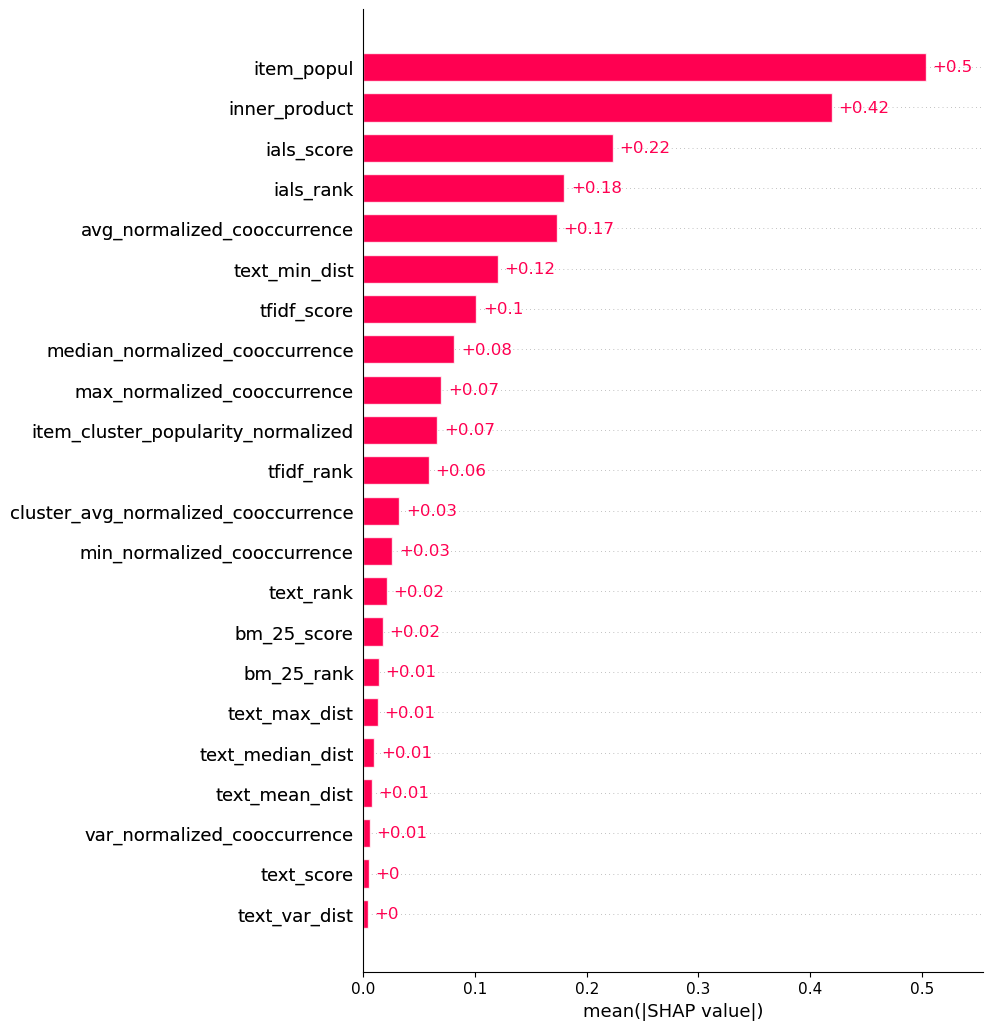

In [26]:
import shap
explainer = shap.Explainer(listwise_model)
shap_values = explainer(test_df[cols])
shap.plots.bar(shap_values, max_display=len(cols))

In [33]:
cols = [col for col in recommendations_df.columns if col not in ['user_id'] + ['item_id'] + ['weight']
       + ['text_var_dist'] + ['text_score'] + ['var_normalized_cooccurrence'] + ['text_mean_dist']
       + ['text_median_dist'] + ['text_max_dist']]

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300)

In [35]:
study.best_trial.params

{'learning_rate': 0.0999216727810641,
 'n_estimators': 1256,
 'max_depth': 4,
 'num_leaves': 17,
 'min_child_samples': 114,
 'reg_lambda': 5.198045171235755,
 'colsample_bytree': 0.7270261311314077,
 'subsample': 0.9206826801502651}

In [36]:
best_params = study.best_trial.params
best_params['objective'] = 'lambdarank'
best_params['metric'] = 'map'
best_params['verbosity'] = -1
best_params['random_state'] = 0

fit_params = {
    'X': train_df[cols],
    'y': train_df['weight'],
    'group': get_group(train_df),
    'eval_set': [(val_df[cols], val_df['weight'])],
    'eval_group': [get_group(val_df)],
    'eval_metric': 'map',
    'eval_at': (1, 5, 10),
    'feature_name': cols,
}
listwise_model = LGBMRanker(**best_params, early_stopping_rounds = 16)
listwise_model.fit(**fit_params)

LGBMRanker(colsample_bytree=0.7270261311314077, early_stopping_rounds=16,
           learning_rate=0.0999216727810641, max_depth=4, metric='map',
           min_child_samples=114, n_estimators=1256, num_leaves=17,
           objective='lambdarank', random_state=0, reg_lambda=5.198045171235755,
           subsample=0.9206826801502651, verbosity=-1)

In [37]:
listwise_df = test_df[["user_id", "item_id"]].copy()
listwise_df["listwise_score"] = listwise_model.predict(test_df[cols])
listwise_df = listwise_df.sort_values(["user_id", "listwise_score"], ascending=[True, False])

In [38]:
listwise_df['rank'] = listwise_df.groupby('user_id').cumcount() + 1

In [39]:
listwise_df.to_parquet('listwise_df_text_final_2.parquet')

In [40]:
listwise_metrics = calc_metrics(
    metrics=metrics,
    reco=(
        listwise_df
        .rename(columns={'listwise_rank': Columns.Rank})
        [[Columns.User, Columns.Item, Columns.Rank]]
    ),
    interactions=(
        warm_test
        [[Columns.User, Columns.Item, Columns.Weight]]
    ),
    prev_interactions=(
        first_train
        [[Columns.User, Columns.Item, Columns.Weight]]
    ),
    catalog=catalog
)

In [41]:
models_results_df_test["LGBM_extra_final_2"] = [listwise_metrics[metric] for metric in models_results_df_test.index]

In [42]:
models_results_df_test

,LGBM_extra_final,LGBM_extra_final_2
hit_rate@1,0.340685,0.339952
hit_rate@5,0.563849,0.563040
hit_rate@10,0.642697,0.642543
Recall@1,0.155151,0.155219
Recall@5,0.318640,0.318033
Recall@10,0.379540,0.379858
MAP@1,0.155151,0.155219
MAP@5,0.254688,0.254656
MAP@10,0.269389,0.269462
MRR@1,0.340685,0.339952


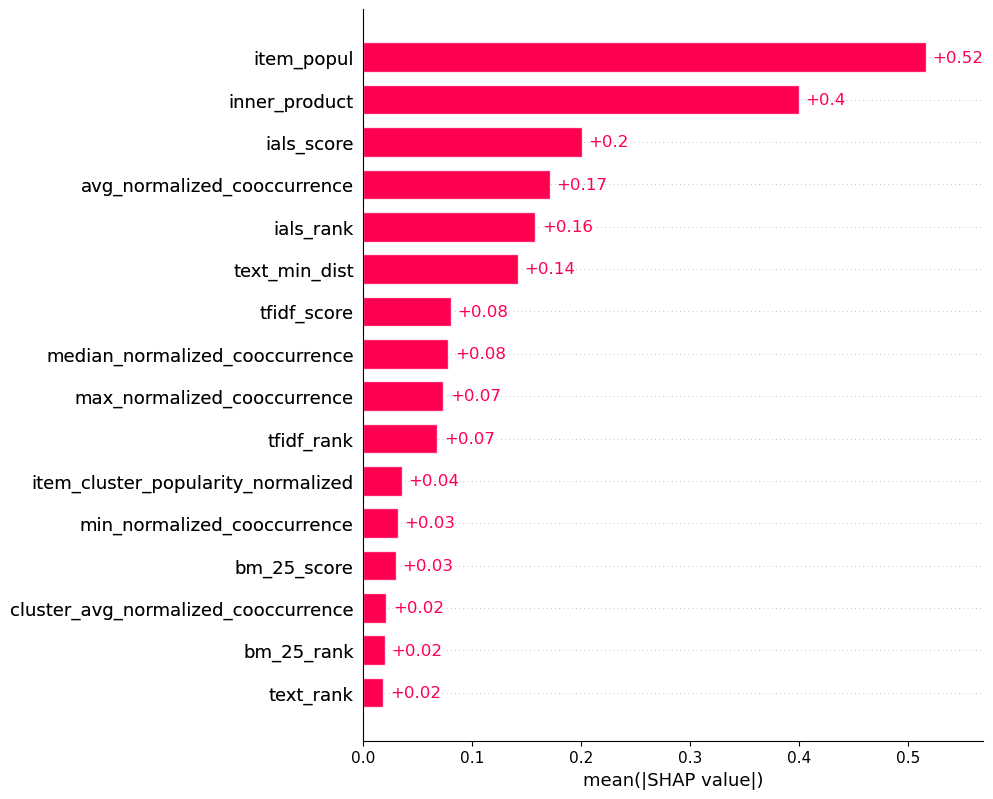

In [43]:
explainer = shap.Explainer(listwise_model)
shap_values = explainer(test_df[cols])
shap.plots.bar(shap_values, max_display=len(cols))